In [163]:
from typing import Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib_inline
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [164]:
class Constants:
    EPOCHS = 500
    LAYERS = 2
    UNITS = 16
    LEARNING_RATE = .001
    BATCH_SIZE = 8
    QUALITY_THRESHOLDS = [4.5, 5.5, 6.5]

In [165]:
class WineModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = Constants.LAYERS
        self.units = Constants.UNITS

        self.input = nn.Linear(11, self.units)
        self.hidden = nn.ModuleList(nn.Linear(self.units, self.units) for _ in range(self.layers))
        self.output = nn.Linear(self.units, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x))

        for layer in self.hidden:
            x = F.leaky_relu(layer(x))

        return self.output(x)

In [166]:
def prepare_data(threshold: float) -> Tuple[DataLoader, DataLoader]:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    data = pd.read_csv(url, sep=';')
    data = data[data["total sulfur dioxide"] < 200]

    cols2zscore = data.keys()
    cols2zscore = cols2zscore.drop("quality")
    data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

    data["boolQuality"] = 0
    tmp = data["quality"] > threshold
    tmp = tmp.astype(int)
    data["boolQuality"] = tmp

    data_tensor = torch.tensor(data[cols2zscore].values).float()
    labels_tensor = torch.tensor(data["boolQuality"].values).float().unsqueeze(dim=1)

    train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

    train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
    test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

    return train_loader, test_loader

In [167]:
def create_model() -> Tuple[WineModel, nn.BCEWithLogitsLoss, torch.optim.Adam]:
    model = WineModel()
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=Constants.LEARNING_RATE)

    return model, loss_fn, optimizer

In [168]:
def train_model(model, loss_fn, optimizer, train_loader, test_loader):
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    train_acc = torch.zeros(Constants.EPOCHS).to(device)
    test_acc = torch.zeros(Constants.EPOCHS).to(device)
    losses = torch.zeros(Constants.EPOCHS).to(device)

    for epoch_no in range(Constants.EPOCHS):
        model.train()

        batch_acc = torch.zeros(len(train_loader)).to(device)
        batch_losses = torch.zeros(len(train_loader)).to(device)

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = loss_fn(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses[batch_idx] = loss.item()
            batch_acc[batch_idx] = 100 * torch.mean(((output > 0) == target).float()).item()

        train_acc[epoch_no] = torch.mean(batch_acc)
        losses[epoch_no] = torch.mean(batch_losses)

        model.eval()
        data, target = next(iter(test_loader))
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(data)

        test_acc[epoch_no] = 100 * torch.mean(((output > 0) == target).float()).item()

    return train_acc, test_acc, losses

In [169]:
def run_the_experiment():
    train_acc = torch.zeros((len(Constants.QUALITY_THRESHOLDS), Constants.EPOCHS)).to(device)
    test_acc = torch.zeros((len(Constants.QUALITY_THRESHOLDS), Constants.EPOCHS)).to(device)

    for threshold_idx, threshold in enumerate(Constants.QUALITY_THRESHOLDS):
        train_loader, test_loader = prepare_data(threshold)
        model, loss_fn, optimizer = create_model()
        model = model.to(device)
        loss_fn = loss_fn.to(device)

        tmp_train_acc, tmp_test_acc, _ = train_model(model, loss_fn, optimizer, train_loader, test_loader)

        train_acc[threshold_idx] = tmp_train_acc
        test_acc[threshold_idx] = tmp_test_acc

    return train_acc, test_acc

In [170]:
train_acc, test_acc = run_the_experiment()

train_acc = train_acc.cpu().numpy()
test_acc = test_acc.cpu().numpy()

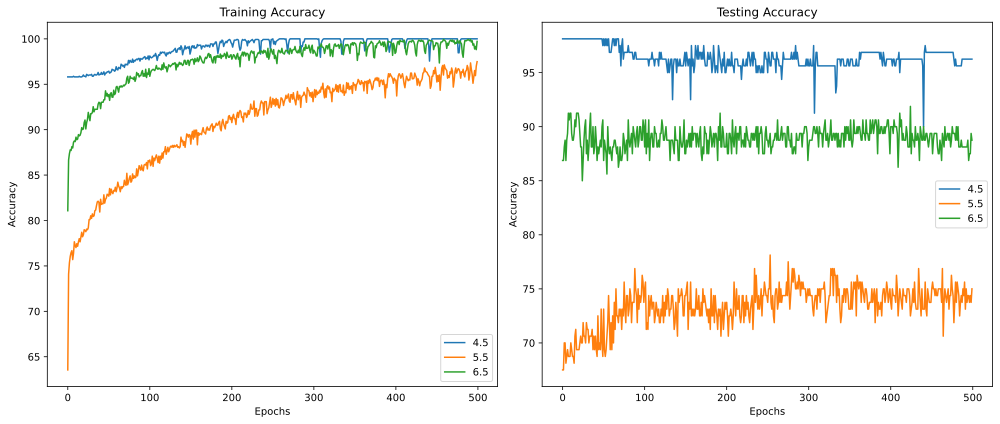

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i in range(train_acc.shape[0]):
    axes[0].plot(train_acc[i, :], label=Constants.QUALITY_THRESHOLDS[i])
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot for test_acc
for i in range(test_acc.shape[0]):
    axes[1].plot(test_acc[i, :], label=Constants.QUALITY_THRESHOLDS[i])
axes[1].set_title('Testing Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()